In [1]:
"""
CONFIGURATION:

In this cell we can read our data and and do all the necessary imports.
"""

import pandas as pd
import numpy as np
from math import sqrt

reviews = pd.read_csv("reviews.tsv", sep="\t")
movie_info = pd.read_csv("movie_info.tsv", sep="\t")
print("Number of movies: ", len(movie_info))

Number of movies:  1560


In [2]:
"""
https://hackernoon.com/popularity-based-song-recommendation-system-without-any-library-in-python-12a4fbfd825e?gi=3c12b77c73f2
https://stackabuse.com/creating-a-simple-recommender-system-in-python-using-pandas/
https://towardsdatascience.com/building-a-movie-recommendation-engine-using-pandas-e0a105ed6762
https://towardsdatascience.com/how-to-build-a-simple-recommender-system-in-python-375093c3fb7d


NOTES:
Neste caso todos os que tem reviews viram o filme
Numa primeira faze podemos eliminar todos os que nao tem rating
Podemos utilizar text mining no review para eferir o rating mas nao é necessario
Tivemos que eliminar os reviews que tinham o valor > que o maximo da scale (referir no relatorio a percentagem que isso ocupava nos reviews)

Popularity:
    Binary - conta os que têm mais reviews
    Non_Binary - conta os que tẽm mais reviews com melhor rating
    
TODO:
    Remover ratings sem escala;
    Podemos eliminar todos que nao tem rating e review X
    
"""
print("NOTES")

NOTES


In [3]:
reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [4]:
movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


#  PRELIMINARY EXPLORATORY DATA ANALYSIS

In [5]:
# Generates column for every genre type in each column
# NOT WORKING YET
# Splits genre into a series of list containing each genre type
movie_info['genre'] = movie_info.genre.str.split('|')

# Removes rows that have no information 
movie_info.dropna(inplace=True)

# Gets a list of each unique genre type
genre_columns = list(set([j for i in movie_info['genre'].tolist() for j in i]))

# Iterating over every list to create and fill values into columns.
for j in genre_columns:
    movie_info[j] = 0
for i in range(movie_info.shape[0]):
    for j in genre_columns:
        if(j in movie_info['genre'].iloc[i]):
            movie_info.loc[i,j] = 1

movie_info

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,...,Faith and Spirituality,Television,Western,Science Fiction and Fantasy,Cult Movies,Musical and Performing Arts,Art House and International,Action and Adventure,Drama,Mystery and Suspense
1,3.0,"New York City, not-too-distant-future: Eric Pa...",R,"[Drama, Science Fiction and Fantasy]",David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,10.0,Some cast and crew from NBC's highly acclaimed...,PG-13,[Comedy],Jake Kasdan,Mike White,"Jan 11, 2002","Jun 18, 2002",$,"41,032,915",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,13.0,"Stewart Kane, an Irishman living in the Austra...",R,[Drama],Ray Lawrence,Raymond Carver|Beatrix Christian,"Apr 27, 2006","Oct 2, 2007",$,"224,114",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
15,22.0,Two-time Academy Award Winner Kevin Spacey giv...,R,"[Comedy, Drama, Mystery and Suspense]",George Hickenlooper,Norman Snider,"Dec 17, 2010","Apr 5, 2011",$,"1,039,869",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
18,25.0,"From ancient Japan's most enduring tale, the e...",PG-13,"[Action and Adventure, Drama, Science Fiction ...",Carl Erik Rinsch,Chris Morgan|Hossein Amini,"Dec 25, 2013","Apr 1, 2014",$,"20,518,224",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19,26.0,A comic series of short vignettes build on one...,R,"[Art House and International, Comedy, Drama, M...",Jim Jarmusch,Jim Jarmusch,"May 14, 2004","Sep 21, 2004",$,"1,971,135",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
29,41.0,"Ken Loach directs Sweet Sixteen, a gritty dram...",R,[Drama],Ken Loach,Paul Laverty,"May 16, 2003","Oct 7, 2003",$,"201,010",...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48,61.0,Death once again shows he's determined to get ...,R,"[Action and Adventure, Drama, Horror, Mystery ...",James Wong,James Wong|Glen Morgan,"Feb 10, 2006","Jul 25, 2006",$,"54,100,000",...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
61,77.0,"Until he was downsized, affable, amiable Larry...",PG-13,"[Comedy, Drama]",Tom Hanks,Tom Hanks|Nia Vardalos,"Jul 1, 2011","Nov 15, 2011",$,"35,565,975",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,87.0,"""Mao's Last Dancer"" is the inspiring true stor...",PG,"[Art House and International, Drama, Musical a...",Bruce Beresford,Jan Sardi,"Aug 20, 2010","May 3, 2011",$,"4,806,750",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Get all unique ids from reviews
reviews_ids = list(set(reviews['id'].tolist()))

# Remove movies that dont have reviews
movie_info = movie_info[movie_info['id'].isin(reviews_ids)]

print("Number of reviews: ", len(reviews))
print("Number of movies: ", len(movie_info))

# Find reviews with no rating
print("Number of reviews with no rating: ", len(reviews.loc[reviews['rating'].isnull()]))

# Find reviews with no rating and no review
# possivle escala trenaria, viu e gostou, viu e nao gostou, viu
print("Number of reviews with no rating and review:", len(reviews.loc[reviews['rating'].isnull() & reviews['review'].isnull()]))

# Remove reviews with no rating
reviews = reviews.loc[~reviews['rating'].isnull()]

Number of reviews:  54432
Number of movies:  209
Number of reviews with no rating:  13517
Number of reviews with no rating and review: 27


In [7]:
"""
TEST Cell
To be removed
"""
# Get all unique ratings
reviews_ratings = list(set(reviews['rating'].tolist()))
print(reviews_ratings)

rating_alpha = [r for r in reviews_ratings if r.isalpha() or "-" in r or "+" in r]
rating_num = [r for r in reviews_ratings if r.isdigit() or ("." in r and "/" not in r)]
rating_outof = [r for r in reviews_ratings if "/" in r]

print(rating_alpha)
print(len(reviews_ratings))
print(len(rating_alpha) + len(rating_outof) + len(rating_num))

['0.5/4', '2.4/5', '7.7/10', '6.7', '7.3/10', '6.5/10', '3.2', '8.2', '2/10', '1/6', '7.9/10', '6.0/10', '2.6/5', '9.2/10', 'D+', '3.6/5', '1.7', '9.6/10', '5.8', '7.2/10', '2.7/5', '4.1', '1.6/5', '4.5/5', '4.3/10', '7', '6/8', '8.4/10', '1.0', '4.9', '3', '3.5', '4.2', '6', '1', '8.3/10', '2/4', '9.8', '8.4', '0/10', '4.3/5', '4.2/5', 'A+', '2.5/5', '0.5/10', '3.8/10', '5.9/10', 'F+', 'D', '3.8/5', '2.2/5', '1-5', '6.2', '1.5', 'D-', '2/5', '3.0/4', '4.1/10', '9.0', '2.6/6', '7.5/10', '7.7', '2.5/10', '4.9/10', 'A', 'B+', '4.5/10', '2.5/4', '3/4', '4.0/4', '4.2/10', '5.5/10', 'C-', '1.5/4', '2.3/4', '6.2/10', '3.1/5', '9.2', '4.4/5', '8.2/10', '9.0/10', '8.1/10', '9', '1/10', '1.9/5', '7.6/10', '5/6', '4.7', '7.1', '3.5/5', '5/10', '7.1/10', '6/10', '9.7', '7.3', '7.8/10', '3/5', '0/6', '5/5', '2.3/10', '0', '4', '3.3/5', '6.3/10', '1/2', '3.1', '2.1/2', '3.3', '1.5/10', '2/6', 'B-', '3.0/10', 'R', '7.8', 'C+', '2.2', '4.0', '1/4', '1/5', '3/6', '8.6/10', '5/4', '4.0/5', 'B', '0.5/5'

In [8]:
"""
Converting all ratings to one single scale /10
For any v/m , being v the value and m the max value in the scale, 
the new rating will be (v * 10)/m
Note: We won't to be able to convert single numbers like ['1', '6', ...] since we don't know the corresponding scale.
      Wee also need to verify if the v is bigger than m
"""
grade_letters = {'A+': 12, 'A': 11, 'A-': 10, 'B+': 9, 'B': 8, 'B-': 7, 
                 'C+':6, 'C':5, 'C-':4, 'D+':3, 'D':2, 'D-':1, 'F': 0}
def convert_rating(rating):
    new_rating = rating
    if '/' in str(rating) and ' ' not in str(rating):
        i = rating.index('/')
        value = float(rating[:i])
        scale_max = float(rating[i+1:])
        if value < scale_max:
            new_rating = value*10/scale_max
        else:
            new_rating = np.nan
    elif str(rating) in grade_letters:
        new_rating = grade_letters[rating]*10/12
    else:
        new_rating = np.nan
    return new_rating

reviews['rating'] = reviews['rating'].apply(convert_rating)

# Remove reviews with no scale
reviews = reviews.loc[~reviews['rating'].isnull()]
reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,6.000000,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
6,3,"Quickly grows repetitive and tiresome, meander...",4.166667,rotten,Eric D. Snider,0,EricDSnider.com,"July 17, 2013"
7,3,Cronenberg is not a director to be daunted by ...,4.000000,rotten,Matt Kelemen,0,Las Vegas CityLife,"April 21, 2013"
11,3,"While not one of Cronenberg's stronger films, ...",5.833333,fresh,Emanuel Levy,0,EmanuelLevy.Com,"February 3, 2013"
12,3,Robert Pattinson works mighty hard to make Cos...,5.000000,rotten,Christian Toto,0,Big Hollywood,"January 15, 2013"


In [9]:
# Create DataFrame with average rating for each movie:
ratings_mean_count = pd.DataFrame(reviews.groupby('id')['rating'].mean())

# Add number of ratings per movie to DataFrame:
ratings_mean_count['rating_counts'] = pd.DataFrame(reviews.groupby('id')['rating'].count())
ratings_mean_count.head()

,rating,rating_counts
id,,
3,5.742925,106
5,6.444444,18
6,5.890244,41
8,6.899123,38
10,5.605932,59


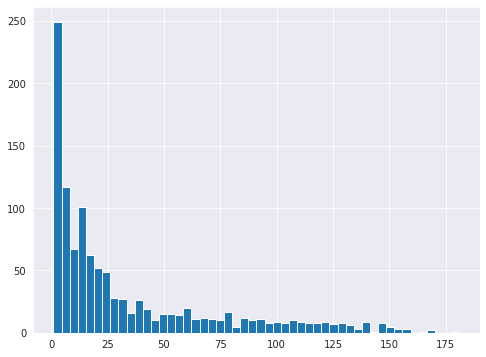

In [10]:
"""
PLOT:

Number of ratings per movie
"""

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('dark')  
%matplotlib inline

plt.figure(figsize=(8,6))  
plt.rcParams['patch.force_edgecolor'] = True  
ratings_mean_count['rating_counts'].hist(bins=50) 

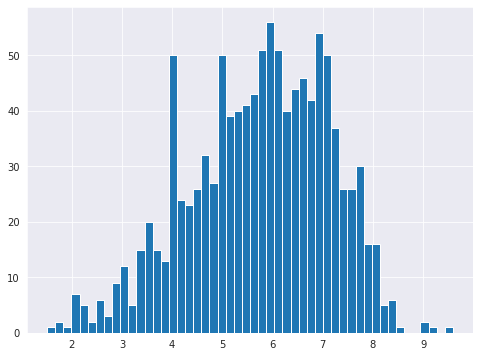

In [11]:
"""
PLOT:

Average ratings per movie
"""

plt.figure(figsize=(8,6))  
plt.rcParams['patch.force_edgecolor'] = True  
ratings_mean_count['rating'].hist(bins=50)  

<Figure size 576x432 with 0 Axes>

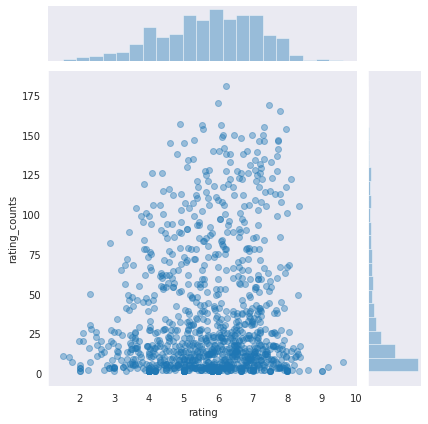

In [12]:
"""
PLOT:

Average ratings against number of ratings per movie
"""

plt.figure(figsize=(8,6))  
plt.rcParams['patch.force_edgecolor'] = True  
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)  

In [13]:
"""
GETTERS:
Some getters functions 
"""

# Gets rating given by a reviewer to a movie
def get_rating(reviewer, movie_id):
    return (reviews.loc[(reviews['critic'] == reviewer) & (reviews['id'] == movie_id),'rating'].iloc[0])

# Gets the list of all movies from a specific reviewer
def get_movies(reviewer):
    return (reviews.loc[(reviews['critic'] == reviewer),'id'].tolist())

#  RECOMMENDER SYSTEMS

##  BINARY

In [14]:
"""
Popularity:
Returns the movie with the most reviews.
"""

def binary_popularity_based(top_n=5):
    # Number of reviews for each movie
    return reviews.groupby('id')['rating'].count().sort_values(ascending=False).head(top_n)

# Top 5 Movies Recommendation
binary_popularity_based(2)

id
1136    181
1071    170
Name: rating, dtype: int64

In [15]:
"""
Association Rules:

"""

'\nAssociation Rules:\n\n'

In [16]:
"""
Collaborative Filtering:
Find which critic and reviewer have identical watched movies
"""

'\nCollaborative Filtering:\nFind which critic and reviewer have identical watched movies\n'

##  NON-BINARY

In [17]:
"""
Popularity:
Returns the movie with the reviews with the best average rating.
"""

def nbinary_popularity_based(top_n=5):
    # Average rating for each movie in descending order:
    return reviews.groupby('id')['rating'].mean().sort_values(ascending=False).head(top_n)

# Top 5 Movies Recommendation
nbinary_popularity_based(2)

id
953    9.595238
368    9.166667
Name: rating, dtype: float64

In [18]:
# Creating table with corresponding movie id and user ratings
user_movie_rating = reviews.pivot_table(index='critic', columns='id', values='rating')
user_movie_rating.head()

def similarity_between_movies(movie_id, top_n=5):
    # Find user ratings for a specific movie id
    movie_ratings = user_movie_rating[movie_id]
    movie_ratings.head()

    # Retrieve all movies that are similar
    movies_like = user_movie_rating.corrwith(movie_ratings)

    # Creates DataFrame with movie id and correlation
    correlation = pd.DataFrame(movies_like, columns=['Correlation'])
    correlation.dropna(inplace=True)

    # Adds number of ratings per movie to correlation DataFrame
    correlation = correlation.join(ratings_mean_count['rating_counts'])

    # Only correlated movies that have more than 50 ratings
    # Which means that at least 50 reviewers rated the same movie
    return correlation[correlation ['rating_counts']>50].sort_values('Correlation', ascending=False).head(top_n)  

similarity_between_movies(1136)

/home/andre/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/andre/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation,rating_counts
id,,
1136,1.000000,181
567,0.718973,60
491,0.713691,55
322,0.688319,150
1339,0.681477,62


In [19]:
"""
Pearson correlation;
Based on: https://towardsdatascience.com/building-a-movie-recommendation-engine-using-pandas-e0a105ed6762
"""
def pearson_correlation_score(reviewer_1, reviewer_2):
    # List of movies watched by both reviewers
    both_watch_count = []
    
    # Finding movies watched by both the reviewers
    for movie_id in reviews.loc[reviews.critic == reviewer_1, 'id'].tolist():
        if movie_id in reviews.loc[reviews.critic == reviewer_2, 'id'].tolist():
            both_watch_count.append(movie_id)
    
    # Returning '0' correlation for no common movies
    if len(both_watch_count) == 0:
        return 0
    
    # Calculating Co-Variances
    rating_sum_1 = sum([get_rating(reviewer_1, movie_id) for movie_id in both_watch_count])
    rating_sum_2 = sum([get_rating(reviewer_2, movie_id) for movie_id in both_watch_count])
    rating_squared_sum_1 = sum([pow(get_rating(reviewer_1, movie_id),2) for movie_id in both_watch_count])
    rating_squared_sum_2 = sum([pow(get_rating(reviewer_2, movie_id),2) for movie_id in both_watch_count])
    product_sum_rating = sum([get_rating(reviewer_1, movie_id) * get_rating(reviewer_2, movie_id) for movie_id in both_watch_count])
    
    # Returning pearson correlation between both the users.
    numerator = product_sum_rating - ((rating_sum_1 * rating_sum_2) / len(both_watch_count))
    denominator = sqrt((rating_squared_sum_1 - pow(rating_sum_1,2) / len(both_watch_count)) * (rating_squared_sum_2 - pow(rating_sum_2,2) / len(both_watch_count)))
    
    # Handling 'Divide by Zero' error.
    if denominator == 0:
        return 0
    return numerator/denominator

print('Pearson Corelation between user ids PJ Nabarro & Emanuel Levy: {}'.format(pearson_correlation_score('PJ Nabarro', 'Emanuel Levy')))

Pearson Corelation between user ids PJ Nabarro & Emanuel Levy: 0.6172133998483683


In [20]:
"""
Association Rules:

"""

'\nAssociation Rules:\n\n'

In [21]:
"""
Collaborative Filtering:
Based on: https://towardsdatascience.com/building-a-movie-recommendation-engine-using-pandas-e0a105ed6762
"""

def get_recommendation(reviewer, top_n=5):
    reviewers = reviews.critic.unique().tolist()
    total = {}
    similarity_sum = {}
    
    # Iterating over subset of reviewers
    for critic in reviewers:
        
        # Not comparing the user to itself
        if reviewer == critic:
            continue
            
        # Getting similarity score between the users
        score = pearson_correlation_score(reviewer, critic)
        
        # Not considering reviewers that have zero or less similarity score
        if score <= 0:
            continue
            
        # Getting weighted similarity score and sum of similarities between both the users.
        for movie_id in get_movies(critic):
            
            # Only considering not watched/rated movies
            if movie_id not in get_movies(reviewer) or get_rating(reviewer, movie_id) == 0:
                total[movie_id] = 0
                total[movie_id] += get_rating(critic, movie_id) * score
                similarity_sum[movie_id] = 0
                similarity_sum[movie_id] += score
        
        # Normalizing ratings
        ranking = [(tot/similarity_sum[movie_id], movie_id) for movie_id,tot in total.items()]
        ranking.sort()
        ranking.reverse()
        
        return pd.DataFrame(ranking, columns=['score', 'id']).head(top_n)
        
get_recommendation('PJ Nabarro')

,score,id
0,9.166667,1929
1,9.166667,1777
2,9.166667,1618
3,9.166667,1344
4,9.166667,1284


## Collaborative Filtering:
Using surprise package and method SVD++

Based on: https://blog.cambridgespark.com/tutorial-practical-introduction-to-recommender-systems-dbe22848392b

In [22]:
"""
Create new dataset to work with surprise
"""
critics = reviews['critic'].unique().tolist()
critic_uid = {}
uid = 0
for critic in critics:
    critic_uid[critic] = uid
    uid += 1
    
critics = reviews['critic'].tolist()
new_column = []
for critic in critics:
    new_column.append(critic_uid[critic])

dataset = reviews.copy()
#new_column = pd.Series(new_column)
#pd.concat([pd.Series(new_column), dataset], axis=1)
dataset.insert(loc=0, column='critic_uid', value=new_column)
#dataset['critic_uid'] = new_column

dataset.drop('review', axis=1, inplace=True)
dataset.drop('top_critic', axis=1, inplace=True)
dataset.drop('publisher', axis=1, inplace=True)
dataset.drop('date', axis=1, inplace=True)
dataset.drop('fresh', axis=1, inplace=True)
dataset.drop('critic', axis=1, inplace=True)
dataset

,critic_uid,id,rating
0,0,3,6.000000
6,1,3,4.166667
7,2,3,4.000000
11,3,3,5.833333
12,4,3,5.000000
13,5,3,6.666667
14,6,3,7.500000
15,7,3,6.000000
16,8,3,8.000000
17,9,3,6.666667


In [23]:
"""
Based on: https://blog.cambridgespark.com/tutorial-practical-introduction-to-recommender-systems-dbe22848392b
"""
import surprise

lower_rating = dataset['rating'].min()
upper_rating = dataset['rating'].max()

print("Review range: {0} to {1}".format(lower_rating, upper_rating))

reader = surprise.Reader(rating_scale = (0.0, 10.0))
data = surprise.Dataset.load_from_df(dataset, reader)

alg = surprise.SVDpp()
output = alg.fit(data.build_full_trainset())

Review range: 0.0 to 10.0


In [24]:
pred = alg.predict(uid='0', iid='3')
score = pred.est
score

5.910940414598952

In [25]:
# Get a list of all unique movies
movies_id = dataset['id'].unique()

# Get a list of movies_id that reviewer 0 has rated
movies_id_0 = dataset.loc[dataset['critic_uid'] == 0, 'id']

# Remove the movie_id that reviewer 0 has rated
movies_ids_to_pred = np.setdiff1d(movies_id, movies_id_0)

In [26]:
testset = [[50, movie_id, 10.0] for movie_id in movies_ids_to_pred]
predictions = alg.test(testset)
predictions[0]

Prediction(uid=50, iid=5, r_ui=9.0, est=5.517323073125775, details={'was_impossible': False})

In [27]:
pred_ratings = np.array([pred.est for pred in predictions])

# Find the index of the maximum predicted rating
i_max = np.argpartition(pred_ratings, -5)[-5:]

# Use this to find the corresponding movie_id to recommend
print('Top movie for reviewer 0: {0}'.format(critics[0]))
for i in i_max:
    movie_id = movies_ids_to_pred[i]
    print('movie_id: {0} with predicted rating: {1}'.format(movie_id, pred_ratings[i]))

Top movie for reviewer 0: PJ Nabarro
movie_id: 1618 with predicted rating: 7.826199184600515
movie_id: 1996 with predicted rating: 8.072830737737275
movie_id: 322 with predicted rating: 8.649932910971184
movie_id: 1691 with predicted rating: 8.09975942399034
movie_id: 290 with predicted rating: 8.813325857158398


In [28]:
# THE THREE CELLS BELOW BELONG TO BINARY COLLABORATIVE FILTERING

In [29]:
"""
Based on: https://medium.com/radon-dev/item-item-collaborative-filtering-with-binary-or-unary-data-e8f0b465b2c3
"""

from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

# create binary dataset, that contains which movies the critics have reviewed 
binary_dataset = pd.get_dummies(dataset.set_index('critic_uid')['id'].astype(str)).max(level=0).sort_index()


def normalize_dataset(dataset):
    dataset_norm = dataset.copy()
    # normalize the data for all users.
    # to make sure that users with more reviews don't influentiate users with less reviews
    magnitude = np.sqrt(np.square(dataset_norm).sum(axis=1))
    dataset_norm = dataset_norm.divide(magnitude, axis='index')
    return dataset_norm


def calculate_similarity(dataset):
    """Calculate the column-wise cosine similarity for a sparse
    matrix. Return a new dataframe matrix with similarities.
    """
    sparse_matrix = sparse.csr_matrix(dataset)
    similarities = cosine_similarity(sparse_matrix.transpose())
    sim = pd.DataFrame(data=similarities, index= dataset.columns, columns= dataset.columns)
    return sim

In [30]:
def binary_collab_item_based(dataset, item, top_n=5):
    # normalize data
    dataset_norm = normalize_dataset(dataset)
    
    # Build similarity matrix
    similarity_matrix = calculate_similarity(dataset_norm)
    predictions = similarity_matrix.loc[str(item)].nlargest(top_n+1)
    
    print("Top " + str(top_n) + " movie recommendation based on movie_id = " + str(item) + ":")
    for index, row in predictions.iteritems():
        print("movie_id: " + str(index) + " with similarity: " + str(round(row,3)))
    #print(similarity_matrix.loc[str(item)].nlargest(top_n+1))


# Top 5 Movies Recommendation for movie_id = 3
binary_collab_item_based(binary_dataset, 3, 10)

Top 10 movie recommendation based on movie_id = 3:
movie_id: 3 with similarity: 1.0
movie_id: 1646 with similarity: 0.132
movie_id: 188 with similarity: 0.13
movie_id: 1136 with similarity: 0.124
movie_id: 23 with similarity: 0.122
movie_id: 1083 with similarity: 0.119
movie_id: 1307 with similarity: 0.118
movie_id: 57 with similarity: 0.108
movie_id: 1013 with similarity: 0.104
movie_id: 1494 with similarity: 0.103
movie_id: 1839 with similarity: 0.096


In [31]:
def binary_collab_user_based(dataset, user, top_n=5):  
    # normalize data
    dataset_norm = normalize_dataset(dataset)
    
    # Build similarity matrix
    similarity_matrix = calculate_similarity(dataset_norm)
    
    # Get movies that user liked
    user_id = critic_uid[user]
    movies_user_liked = dataset_norm.loc[user_id]
    movies_user_liked = movies_user_liked[movies_user_liked >0].index.values
    
    # Users likes for all items as a sparse vector.
    user_rating_vector = dataset_norm.loc[user_id]
    
    # Calculate the score.
    score = similarity_matrix.dot(user_rating_vector).div(similarity_matrix.sum(axis=1))
    
    # Remove the user liked movies from the recommendation.
    score = score.drop(movies_user_liked)
    
    predictions = score.nlargest(top_n)
    
    print("Top " + str(top_n) + " movie recommendation based on critic_id = " + str(user) + ":")
    for index, row in predictions.iteritems():
        print("movie_id: " + str(index) + " with similarity: " + str(round(row,3)))
    #print(score.nlargest(top_n))


# Top 5 Movies Recommendation for user 'PJ Nabarro'
binary_collab_user_based(binary_dataset, 'PJ Nabarro', 5)

Top 5 movie recommendation based on critic_id = PJ Nabarro:
movie_id: 1110 with similarity: 0.026
movie_id: 821 with similarity: 0.026
movie_id: 968 with similarity: 0.011
movie_id: 810 with similarity: 0.011
movie_id: 1172 with similarity: 0.011


In [32]:
movies_in_review = reviews['id'].unique().tolist()
print(len(movies_in_review))

# este print está na parte do Data Analysis
print("Number of movies: ", len(movie_info))

1112
Number of movies:  209
